# Prerequisites

In [1]:
%load_ext autoreload
%autoreload 2

import glob
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
from data import WasteSet, get_waste, standardize_inv
from PIL import Image
from selectivesearch import SelectiveSearch
from tqdm.notebook import tqdm
from utils import show_annotation, show_cmap

data_path = '/dtu/datasets1/02514/data_wastedetection'

# Dataloader

In [2]:
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = get_waste(
    8, num_workers=8, data_augmentation=True, supercategories=True)

len(train_dataset), len(val_dataset), len(test_dataset)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


(1050, 225, 225)

In [3]:
ims, targets = next(iter(train_loader))
len(ims), len(targets)

(8, 8)

In [4]:
targets[0]

{'bboxes': tensor([[0.3427, 0.5458, 0.1773, 0.4542]]),
 'category_ids': tensor([24]),
 'size': (512, 512)}

(0.3427110016345978, 0.5457730889320374, 0.1773231029510498, 0.45422688126564026)


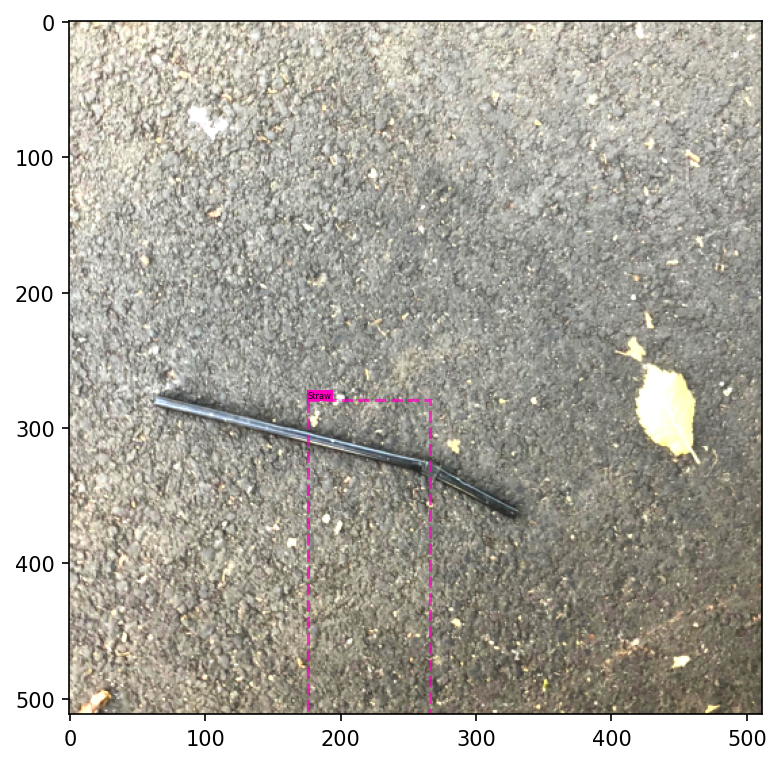

In [9]:
idx = 0

im, _ = standardize_inv(ims[idx], None)
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=150)
ax.imshow(np.moveaxis(im.numpy(), 0, 2))
show_annotation(targets[idx], ax, names=train_dataset.cat_names)

In [6]:
ims[2].shape

torch.Size([3, 512, 512])

# Object proposals

In [7]:
# Selective search module
ss = SelectiveSearch(mode='f', nkeep=200)

ims, targets = next(iter(dataloader))

NameError: name 'dataloader' is not defined